## 心理学
- 动物需要在复杂环境下有效关注值得注意的点
- 随意(随着意志)的线索
- 举例如下:这里的杯子是不随意线索（一眼就能看到），这里的书是随意线索(想看书就刻意去找书)
![softmax-description](./imgs/64-1.png)


## 注意力机制
- 卷积、全连接、池化层都只考虑不随意线索
- 注意力机制则显式地考虑随意线索
- 随意线索 - query (对应 “想要干什么”):通过查询去寻找比较感兴趣的内容
- 每个输入 - 一个值(value)和不随意线索(key)的对 - value是根据需求可变的（对应“环境”）
- 通过注意力池化层来有偏向性地选择某些输入

## 非参注意力池化层(不需要学额外的参数)
- 给定数据(x_i,y_i),i = 1,...,n
- x_i是key, y_i是value.
- 平均池化是最简单的方案:这里的x就是query
![softmax-description](./imgs/64-2.png)

- 更好的方案是60年代提出来的Nadaraya-Wastson核回归
- 先把x和所有的候选的$x_i$相减，然后除以之和。K是核函数
- 类似于每一项$y_i$加权，再对y_i求和。
![softmax-description](./imgs/64-3.png)

## Nadaraya-Wastson核回归
- 使用高斯核
- 这里有一个负号，因为xi和x距离越近，xi对x越重要
![softmax-description](./imgs/64-4.png)

## 参数化的注意力机制
- 在之前的基础上引入可以学习的w
![softmax-description](./imgs/64-5.png)

## 总结
- 心理学认为人通过随意线索和不随意线索选择注意点
- 注意力机制中，通过query（随意线索）和key(不随意线索)来有偏向性地选择输入
- 一般写作:
![softmax-description](./imgs/64-6.png)

- 可以在空间维度引入attetion机制（比如inception）
- 也可以在通道维度(channel)上增加attention机制
- 可以同时在空间维度和通道维度增加attention机制

In [2]:
%matplotlib inline
import torch
from torch import nn
import d2l

In [3]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 训练样本的输入

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5]) # 画线
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5); # 画点

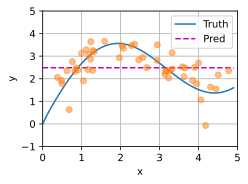

In [5]:
# repeat_interleave:每一行都包含着相同的测试输入（例如：同样的查询）
y_hat = torch.repeat_interleave(y_train.mean(), n_test) # 这里是取y的均值，不管x的值，对应非随意线索
plot_kernel_reg(y_hat)

X_repeat-shape: torch.Size([50, 50])
x_train-shape: torch.Size([50])
x_test-shape: torch.Size([50])
attention_weights-shape: torch.Size([50, 50])


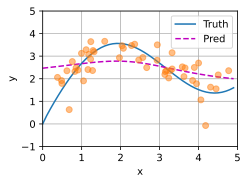

In [6]:
# `X_repeat` 的形状: (`n_test`, `n_train`),
# repeat_interleave:每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train)) # X_repeat的尺寸:(`n_test`, `n_train`),
print('X_repeat-shape:',X_repeat.shape)
print('x_train-shape:',x_train.shape)
print('x_test-shape:',x_test.shape)
# `x_train` 包含着键。`attention_weights` 的形状：(`n_test`, `n_train`),
# 每一行都包含着要在给定的每个查询的值（`y_train`）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
print('attention_weights-shape:',attention_weights.shape)
# `y_hat` 的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

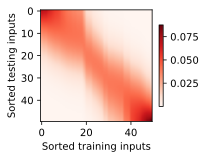

In [7]:
# 观察注意力权重
# 第i个测试样本，给每一个训练样本的权重
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), 
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs') # torch.Size([1, 1, 50, 50])

In [8]:
# bmm: 批量矩阵乘法: 对小批量里的每一个矩阵进行矩阵乘法
X = torch.ones((2,1,4))
Y = torch.ones((2,4,4))
torch.bmm(X,Y).shape

torch.Size([2, 1, 4])

In [9]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)) # (2,1,10)*(2,10,1)

tensor([[[ 4.5000]],

        [[14.5000]]])

In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 在数学上，w用于控制高斯核窗口的大小(是否平滑)
        # 这里的w就是一个标量
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    def forward(self, queries, keys, values):
        # `queries` 和 `attention_weights` 的形状为 (查询个数, “键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1) # 计算注意力权重
        # `values` 的形状为 (查询个数, “键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1) # 权重乘以values等于

In [38]:
# `X_tile` 的形状: (`n_train`, `n_train`), 每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1)) # torch.Size([50, 50]
# `Y_tile` 的形状: (`n_train`, `n_train`), 每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# `keys` 的形状: ('n_train', 'n_train' - 1)
# X_tile[(1 - torch.eye(n_train)).type(torch.bool)] 这一步删掉所有bool=false的行，
# 即把每一行自己和自己的那一个元素删掉
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))  # torch.Size([50, 49])
# `values` 的形状: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) # torch.Size([50, 49])

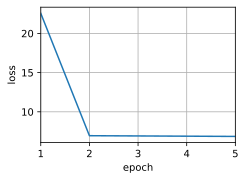

In [39]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    # 注意：L2 Loss = 1/2 * MSE Loss。
    # PyTorch 的 MSE Loss 与 MXNet 的 L2Loss 差一个 2 的因子，因此被除2。
    # queries, keys, values 对应 x_train, keys, values
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

In [23]:
# 查看w的值
for parameters in net.parameters(): 
    print(parameters)

Parameter containing:
tensor([4.9816], requires_grad=True)


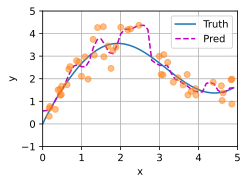

In [41]:
# `keys` 的形状: (`n_test`, `n_train`), 每一行包含着相同的训练输入（例如：相同的键）
keys = x_train.repeat((n_test, 1))
# `value` 的形状: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

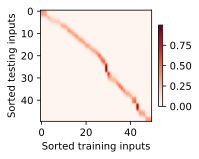

In [42]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')